# Generating Synthetic Data
In data analysis, it is important that we have the ability to test our assumptions. One powerful tool to enable these tests is simulation. In 3ML, we have several ways to generate synthetic data sets both from models and from fits.

## Synthetic data from spectra

### Genertating data from models

Most of the current plugins support the ability to generate synthetic data directly from a model. This can be very useful to assertain the detectability of a source/component/line or simply to see how models look once they are transformed into data. Below we will demonstrate how different plugins transform a model into synthetic data.

#### XYLike

In many of the examples, the basic XYLike plugin has been used to generate synthetic data. Here, we will revisit the plugin for completeness.

In [15]:
from threeML import *
import numpy as np

%matplotlib inline
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)


import matplotlib.pyplot as plt

plt.style.use("mike")


import warnings

warnings.simplefilter("ignore")

Using Gaussian statistic (equivalent to chi^2) with the provided errors.


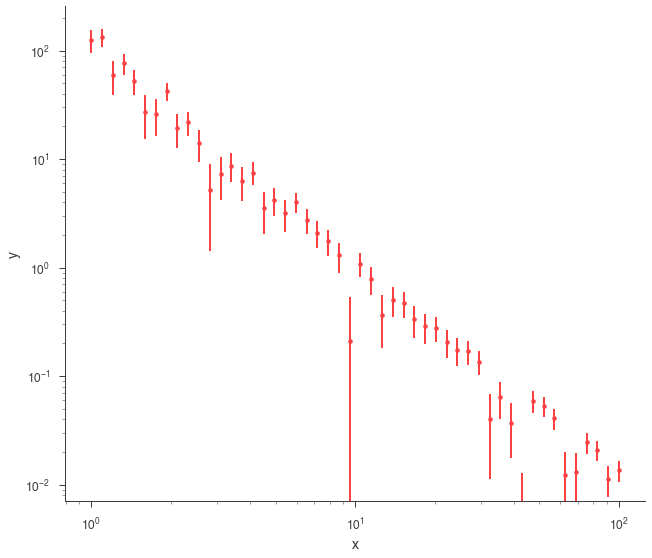

In [2]:
# Select an astromodels function to from which to simualte
generating_function = Powerlaw(K=1.0, index=-2, piv=10.0)

# set up the x grig points
x_points = np.logspace(0, 2, 50)

# call the from_function classmethod
xyl_generator = XYLike.from_function(
    "sim_data",
    function=generating_function,
    x=x_points,
    yerr=0.3 * generating_function(x_points),
)


xyl_generator.plot(x_scale="log", y_scale="log")

#### SpectrumLike

Generating synthetic spectra from SpectrumLike (non-energy dispersed count spectra) can take many forms with different inputs.

First, let's set the energy bins we will use for all generated spectra

In [3]:

energies = np.logspace(0,2,51)

# create the low and high energy bin edges
low_edge = energies[:-1]
high_edge = energies[1:]

Now, let's use a blackbody for the source spectrum.

In [4]:
# get a BPL source function
source_function = Blackbody(K=1, kT = 5.)

##### Poisson spectrum with no background

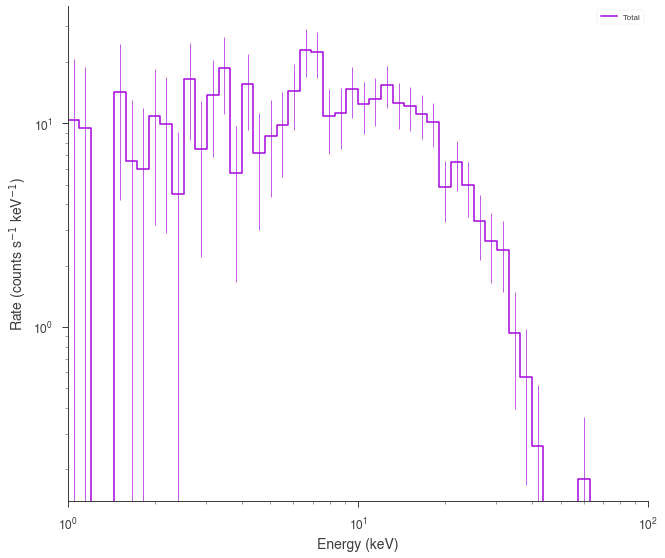

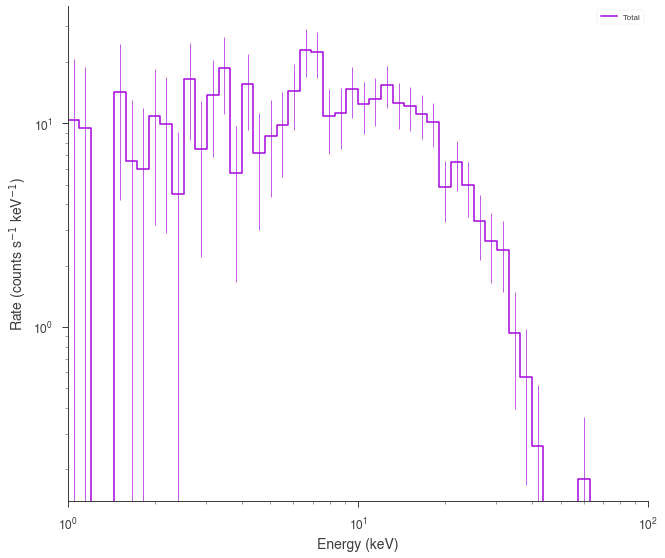

In [5]:
spectrum_generator = SpectrumLike.from_function('fake',
                                               source_function=source_function,
                                               energy_min=low_edge,
                                               energy_max=high_edge)


spectrum_generator.view_count_spectrum()

##### Gaussian spectrum with no background

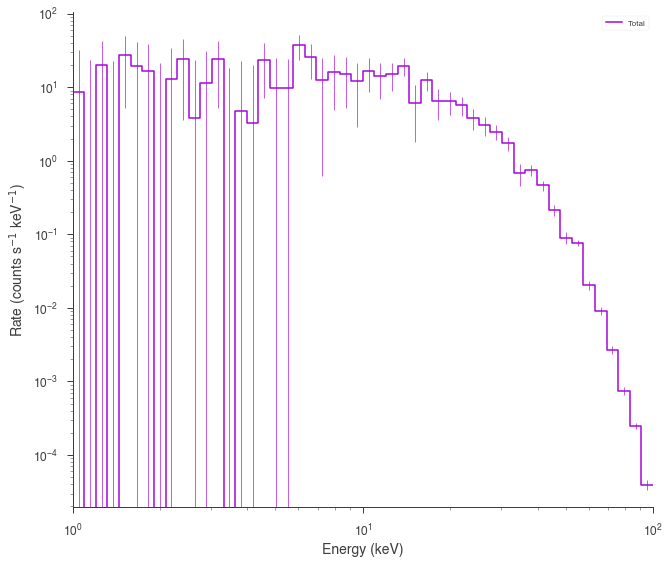

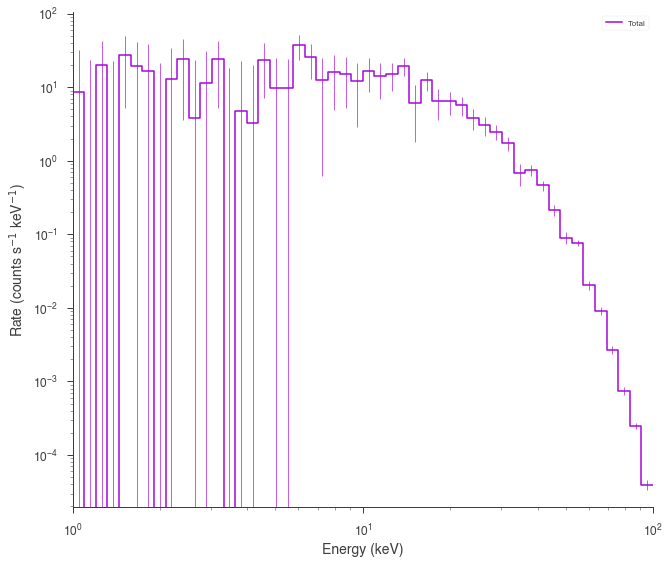

In [6]:
spectrum_generator = SpectrumLike.from_function('fake',
                                               source_function=source_function,
                                               source_errors= 0.5 * source_function(low_edge),
                                               energy_min=low_edge,
                                               energy_max=high_edge)


spectrum_generator.view_count_spectrum()

##### Poisson spectrum with Poisson Background

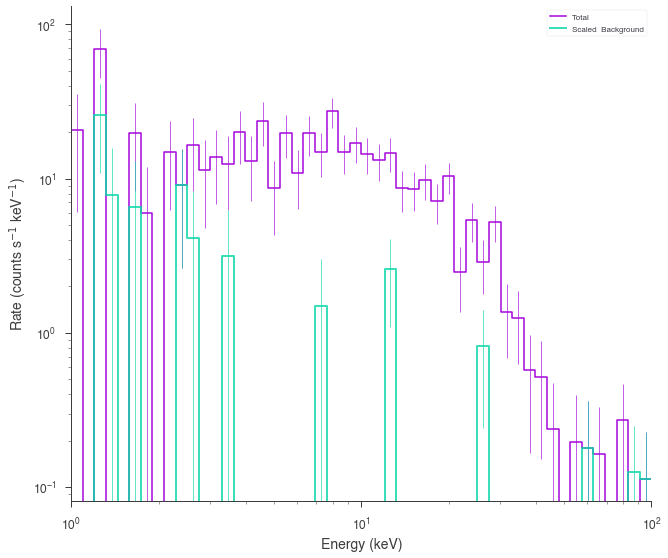

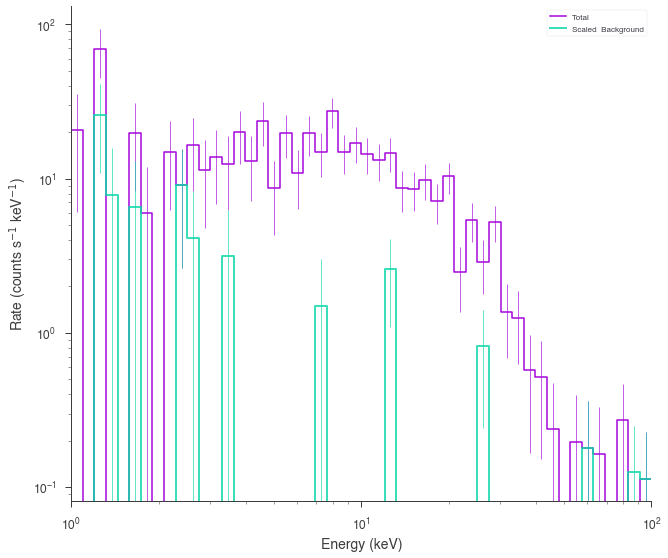

In [7]:

# power law background function
background_function = Powerlaw(K=.7,index=-1.5, piv=10.)

spectrum_generator = SpectrumLike.from_function('fake',
                                               source_function=source_function,
                                               background_function=background_function,
                                               energy_min=low_edge,
                                               energy_max=high_edge)


spectrum_generator.view_count_spectrum()

##### Poisson spectrum with Gaussian background

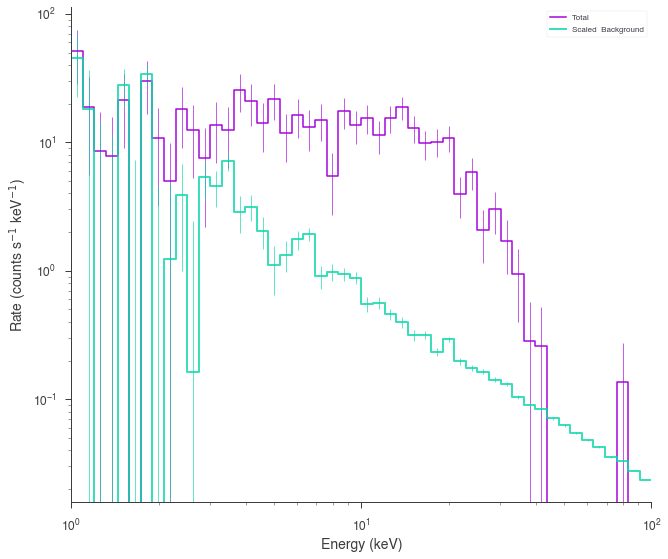

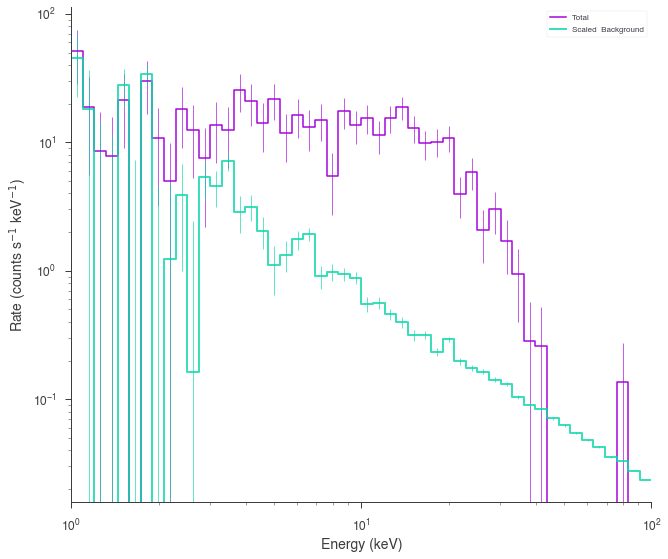

In [8]:

spectrum_generator = SpectrumLike.from_function('fake',
                                               source_function=source_function,
                                               background_function=background_function,
                                               background_errors= 0.1 * background_function(low_edge),
                                               energy_min=low_edge,
                                               energy_max=high_edge)


spectrum_generator.view_count_spectrum()

#### DispersionSpectrumLike

DispersionSpectrumLike behaves in the same fashion as SpectrumLike except that a 3ML Instrument response must be set which means that the energy bins do not need to be specified as they are derived from the response

Let's grab a response from an instrument.

In [9]:
from threeML.io.package_data import get_path_of_data_file
from threeML.utils.OGIP.response import OGIPResponse

# we will use a demo response
response = OGIPResponse(get_path_of_data_file("datasets/ogip_powerlaw.rsp"))

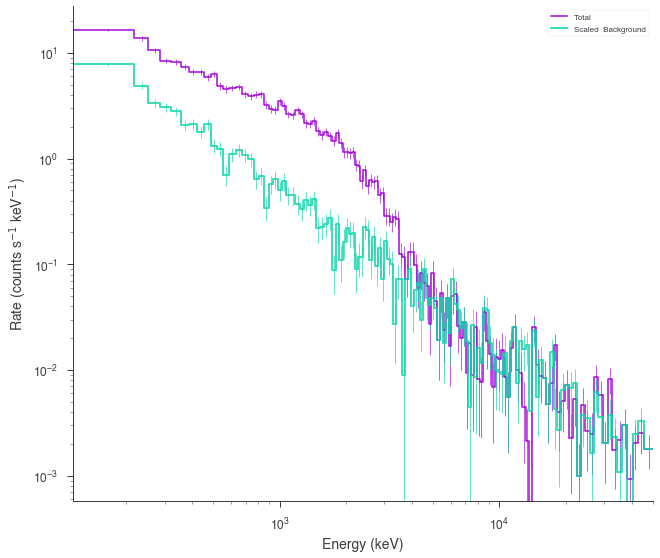

In [16]:
# rescale the functions for the response
source_function = Blackbody(K=1e-7, kT=500.0)
background_function = Powerlaw(K=1, index=-1.5, piv=1.0e3)
spectrum_generator = DispersionSpectrumLike.from_function(
    "fake",
    source_function=source_function,
    background_function=background_function,
    response=response,
)

spectrum_generator.view_count_spectrum();

### Generating spectra from fitted models

When performing goodness of fit tests, likelihood ratio tests (both automatic in 3ML) or posterior predictive checks, we need to generate synthetic data from our fitted models. Therefore, we proved methods to do this for most current plugins.

#### XYLike

Let's load some example, generic XY data and fit it with a power law.

Using Gaussian statistic (equivalent to chi^2) with the provided errors.
Best fit values:



,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(8.8 +/- 0.8) x 10^-1,1 / (cm2 keV s)
source.spectrum.main.Powerlaw.index,-1.974 +/- 0.033,



Correlation matrix:



1.00,-0.87
-0.87,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,22.76276
xyl,22.76276



Values of statistical measures:



,statistical measures
AIC,49.780839
BIC,53.349566


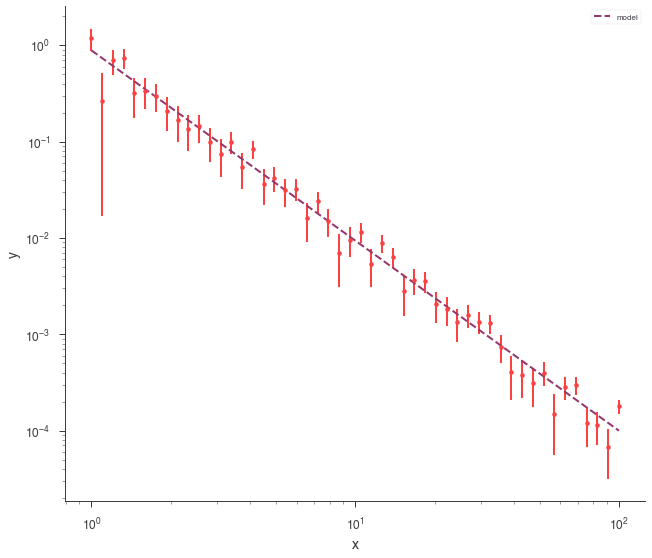

In [11]:
data_path = get_path_of_data_file("datasets/xy_powerlaw.txt")


xyl = XYLike.from_text_file("xyl", data_path)

fit_function = Powerlaw()

xyl.fit(fit_function)

xyl.plot(x_scale="log", y_scale="log")

Once our fit has been finished, we can produce simulated data sets from those model parameters.

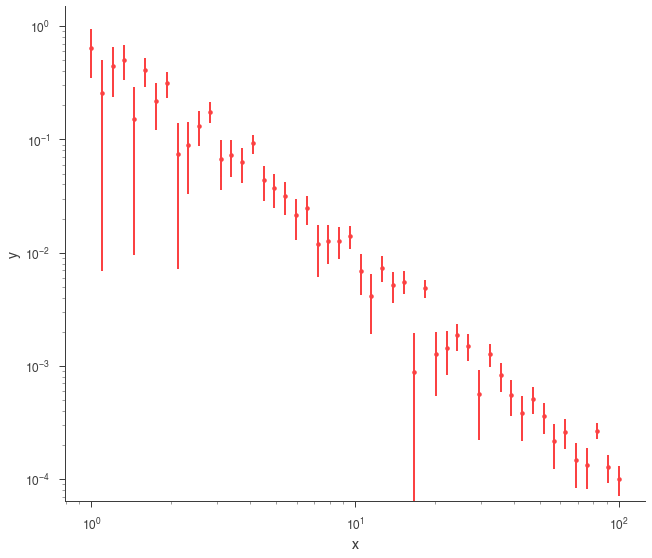

In [12]:
synthetic_xyl = xyl.get_simulated_dataset()

synthetic_xyl.plot(x_scale="log", y_scale="log")

#### SpectrumLike and DispersionSpectrumLike (OGIPLike)

Both spectrum plugins work in the same way when generating data from a fit. They both keep track of the statistical properties of the likelihoods in the plugin so that the simulated datasets have the appropriate statistical properties. Additionally, background, responsses, etc. are simulated and/or kept track of as well.

Let's fit an example energy dispersed spectrum.

Auto-probed noise models:
- observation: poisson
- background: poisson
Best fit values:



,result,unit
parameter,,
ps.spectrum.main.Cutoff_powerlaw.K,(5.2 -2.6 +5) x 10^-1,1 / (cm2 keV s)
ps.spectrum.main.Cutoff_powerlaw.index,-1.88 +/- 0.12,
ps.spectrum.main.Cutoff_powerlaw.xc,(1.7 -1.1 +3.0) x 10^4,keV



Correlation matrix:



1.00,-1.00,0.72
-1.00,1.00,-0.76
0.72,-0.76,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
ogip,180.942677
total,180.942677



Values of statistical measures:



,statistical measures
AIC,368.078902
BIC,376.441445


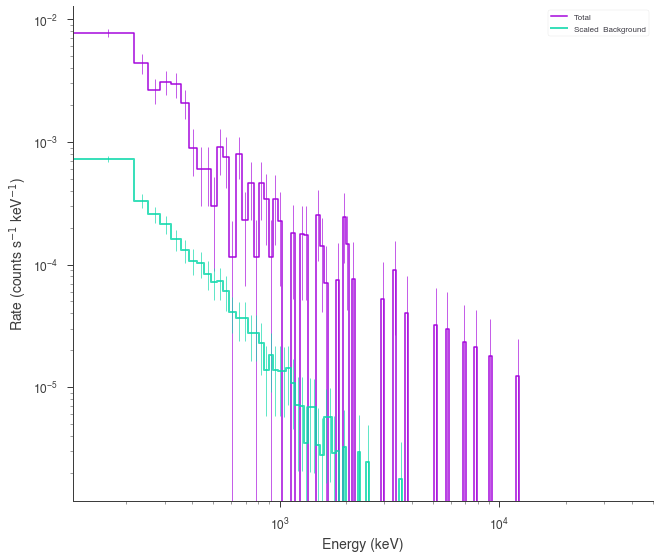

In [13]:
ogip_data = OGIPLike(
    "ogip",
    observation=get_path_of_data_file("datasets/ogip_powerlaw.pha"),
    background=get_path_of_data_file("datasets/ogip_powerlaw.bak"),
    response=get_path_of_data_file("datasets/ogip_powerlaw.rsp"),
)

ogip_data.view_count_spectrum()
# define the function
fit_function = Cutoff_powerlaw()

# define the point source
point_source = PointSource("ps", 0, 0, spectral_shape=fit_function)

# define the model
model = Model(point_source)

# create a data list
datalist = DataList(ogip_data)

# make the joint likelihood
jl = JointLikelihood(model, datalist)

# fit
jl.fit()

Now we can now generate synthetic datasets from the fitted model. This will include the background sampled properly from the profile likelihood. The instrument response is automatically passed to the new plugin.

Now using 128 channels out of 128


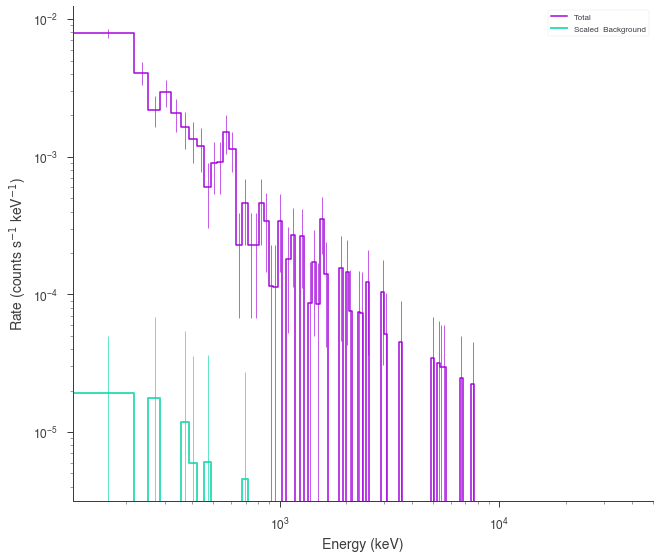

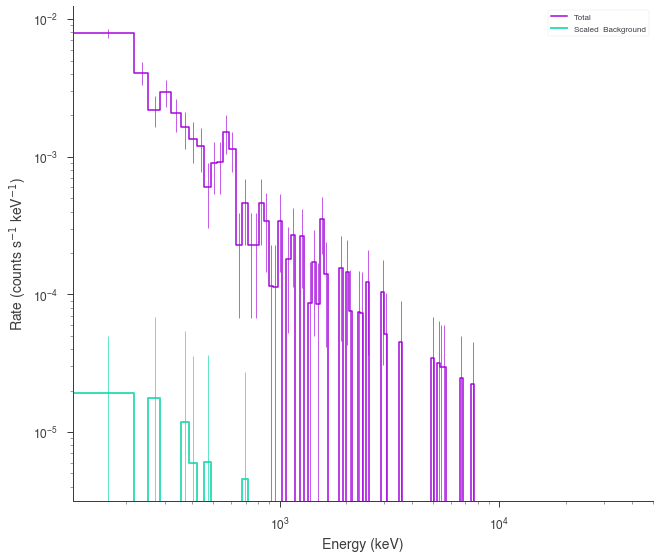

In [14]:
synthetic_ogip = ogip_data.get_simulated_dataset()

synthetic_ogip.view_count_spectrum()